In [8]:
import overpy
import pandas as pd
import folium
import random

# إنشاء عميل Overpass API
api = overpy.Overpass()

# قائمة المحافظات (إحداثيات الوسط لكل محافظة)
governorates = {
    "Cairo": (30.0444, 31.2357),
    "Giza": (29.987, 31.2118),
    "Alexandria": (31.2001, 29.9187),
    "Dakahlia": (31.0409, 31.3785),
    "Sharqia": (30.7306, 31.641),
    "Minya": (28.0900, 30.7600),
    "Sohag": (26.556, 31.695)
}

radius = 10000  # نصف القطر بالكيلومتر

# جمع البيانات
data = []
for governorate, (lat, lon) in governorates.items():
    query = f"""
      [out:json];
      (
        node["amenity"="restaurant"](around:{radius},{lat},{lon});
        node["amenity"="hospital"](around:{radius},{lat},{lon});
        node["tourism"="hotel"](around:{radius},{lat},{lon});
      );
      out body;
    """
    result = api.query(query)
    for node in result.nodes:
        name = node.tags.get("name", "Unknown")
        amenity = node.tags.get("amenity", "Unknown")
        waste_type = (
            "organic" if amenity == "restaurant" else
            "medical" if amenity == "hospital" else
            "mixed" if amenity == "hotel" else
            "unknown"
        )
        data.append({
            "governorate": governorate,
            "latitude": node.lat,
            "longitude": node.lon,
            "name": name,
            "type": amenity,
            "waste_type": waste_type
        })

# تحويل البيانات إلى DataFrame
df = pd.DataFrame(data)

# معالجة القيم غير المعروفة (Unknown)
df["type"] = df["type"].replace("Unknown", "hotel")  # تعيين الفنادق افتراضيًا
df["waste_type"] = df["waste_type"].replace("unknown", "mixed")  # تعيين نوع النفايات الافتراضي

# إضافة الكثافة السكانية بناءً على المنطقة باستخدام نطاق ديناميكي
def generate_population_density(governorate):
    if governorate in ["Cairo", "Giza", "Alexandria"]:
        return random.randint(10000, 20000)  # مناطق حضرية
    else:
        return random.randint(1000, 5000)  # مناطق ريفية

df["population_density"] = df["governorate"].apply(generate_population_density)

# إضافة وزن النفايات بناءً على نوع النفايات باستخدام نطاق ديناميكي
def generate_waste_weight(waste_type):
    if waste_type == "organic":
        return random.randint(30, 70)  # مطاعم
    elif waste_type == "medical":
        return random.randint(150, 300)  # مستشفيات
    elif waste_type == "mixed":
        return random.randint(100, 200)  # فنادق
    else:
        return 0  # إذا لم يُحدد النوع

df["waste_weight"] = df["waste_type"].apply(generate_waste_weight)

# حساب مستوى التلوث (pollution_level) مع بعض العشوائية
def calculate_pollution_level(row):
    base_pollution = row["waste_weight"] * row["population_density"]
    variability = random.uniform(0.9, 1.1)  # تأثير بين -10% و +10%
    return base_pollution * variability

df["pollution_level"] = df.apply(calculate_pollution_level, axis=1)

# طباعة أول 10 صفوف للتأكد من البيانات
print("DataFrame contents after processing:")
print(df.head(2000))

# إنشاء الخريطة
map_points = folium.Map(location=[30.0444, 31.2357], zoom_start=7)

# إضافة نقاط لكل منشأة
for _, row in df.iterrows():
    color = (
        "green" if row["type"] == "restaurant" else
        "red" if row["type"] == "hospital" else
        "blue"
    )
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=7,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=(
            f"Name: {row['name']}<br>"
            f"Governorate: {row['governorate']}<br>"
            f"Type: {row['type']}<br>"
            f"Waste Type: {row['waste_type']}<br>"
            f"Population Density: {row['population_density']}<br>"
            f"Waste Weight: {row['waste_weight']}<br>"
            f"Pollution Level: {row['pollution_level']:.2f}"
        )
    ).add_to(map_points)

# حفظ الخريطة
map_points.save("points_map_without_geopy.html")
print("Map saved to 'points_map_without_geopy.html'")


DataFrame contents after processing:
     governorate    latitude   longitude               name        type  \
0          Cairo  30.0638579  31.2191142        فندق لونشان       hotel   
1          Cairo  30.0645602  31.2159286      فندق أم كلثوم       hotel   
2          Cairo  30.0693145  31.2198471    ديدوس أل دينتيه  restaurant   
3          Cairo  30.0591691  31.2241754      Maison Thomas  restaurant   
4          Cairo  30.0647750  31.2098013         معهد القلب    hospital   
...          ...         ...         ...                ...         ...   
1039       Sohag  26.5507538  31.6990896       فندق الاندلس       hotel   
1040       Sohag  26.5461182  31.6978573  د.عبد الناصر بدوى    hospital   
1041       Sohag  26.5511421  31.7000784           فندق دهب       hotel   
1042       Sohag  26.5502233  31.6999617        فندق السلام       hotel   
1043       Sohag  26.5612995  31.6984195      Al Safa Hotel       hotel   

     waste_type  population_density  waste_weight  pollution_l

In [9]:
from IPython.display import IFrame
IFrame('points_map_without_geopy.html', width=2500, height=2300)


In [34]:
import overpy
import pandas as pd
import folium
import random

# إنشاء عميل Overpass API
api = overpy.Overpass()

# قائمة المحافظات (إحداثيات الوسط لكل محافظة)
governorates = {
    "Cairo": (30.0444, 31.2357),
    "Giza": (29.987, 31.2118),
    "Alexandria": (31.2001, 29.9187),
    "Dakahlia": (31.0409, 31.3785),
    "Sharqia": (30.7306, 31.641),
    "Minya": (28.0900, 30.7600),
    "Sohag": (26.556, 31.695)
}

radius = 10000  # نصف القطر بالكيلومتر

# جمع البيانات
data = []
for governorate, (lat, lon) in governorates.items():
    query = f"""
      [out:json];
      (
        node["amenity"="restaurant"](around:{radius},{lat},{lon});
        node["amenity"="hospital"](around:{radius},{lat},{lon});
        node["tourism"="hotel"](around:{radius},{lat},{lon});
      );
      out body;
    """
    result = api.query(query)
    for node in result.nodes:
        name = node.tags.get("name", "Unknown")
        amenity = node.tags.get("amenity", "Unknown")
        waste_type = (
            "organic" if amenity == "restaurant" else
            "medical" if amenity == "hospital" else
            "mixed" if amenity == "hotel" else
            "unknown"
        )
        data.append({
            "governorate": governorate,
            "latitude": node.lat,
            "longitude": node.lon,
            "name": name,
            "type": amenity,
            "waste_type": waste_type
        })

# تحويل البيانات إلى DataFrame
df = pd.DataFrame(data)

# معالجة القيم غير المعروفة (Unknown)
df["type"] = df["type"].replace("Unknown", "hotel")  # تعيين الفنادق افتراضيًا
df["waste_type"] = df["waste_type"].replace("unknown", "mixed")  # تعيين نوع النفايات الافتراضي

# إضافة الكثافة السكانية بناءً على المنطقة باستخدام نطاق ديناميكي
def generate_population_density(governorate):
    if governorate in ["Cairo", "Giza", "Alexandria"]:
        return random.randint(10000, 20000)  # مناطق حضرية
    else:
        return random.randint(1000, 5000)  # مناطق ريفية

df["population_density"] = df["governorate"].apply(generate_population_density)

# إضافة وزن النفايات بناءً على نوع النفايات باستخدام نطاق ديناميكي
def generate_waste_weight(waste_type):
    if waste_type == "organic":
        return random.randint(30, 70)  # مطاعم
    elif waste_type == "medical":
        return random.randint(150, 300)  # مستشفيات
    elif waste_type == "mixed":
        return random.randint(100, 200)  # فنادق
    else:
        return 0  # إذا لم يُحدد النوع

df["waste_weight"] = df["waste_type"].apply(generate_waste_weight)

# حساب مستوى التلوث (pollution_level) مع بعض العشوائية
def calculate_pollution_level(row):
    base_pollution = row["waste_weight"] * row["population_density"]
    variability = random.uniform(0.9, 1.1)  # تأثير بين -10% و +10%
    return base_pollution * variability

df["pollution_level"] = df.apply(calculate_pollution_level, axis=1)

# حفظ البيانات إلى ملف CSV
df.to_csv("waste_data.csv", index=False)
print("Data saved to 'wastee_data.csv'")

# إنشاء الخريطة
map_points = folium.Map(location=[30.0444, 31.2357], zoom_start=7)

# إضافة نقاط لكل منشأة
for _, row in df.iterrows():
    color = (
        "green" if row["type"] == "restaurant" else
        "red" if row["type"] == "hospital" else
        "blue"
    )
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=7,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=(
            f"Name: {row['name']}<br>"
            f"Governorate: {row['governorate']}<br>"
            f"Type: {row['type']}<br>"
            f"Waste Type: {row['waste_type']}<br>"
            f"Population Density: {row['population_density']}<br>"
            f"Waste Weight: {row['waste_weight']}<br>"
            f"Pollution Level: {row['pollution_level']:.2f}"
        )
    ).add_to(map_points)

# حفظ الخريطة
map_points.save("points_map_without_geopy.html")
print("Map saved to 'points_map_without_geopy.html'")


Data saved to 'wastee_data.csv'
Map saved to 'points_map_without_geopy.html'


In [35]:
from IPython.display import IFrame
IFrame('points_map_without_geopy.html', width=1200, height=1000)


C:\Users\abdal\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Average Pollution Level per Cluster:
cluster
0    7.187550e+05
1    2.317531e+06
2    3.824860e+06
Name: pollution_level, dtype: float64
Enhanced map with clusters saved to 'enhanced_clustered_map.html'


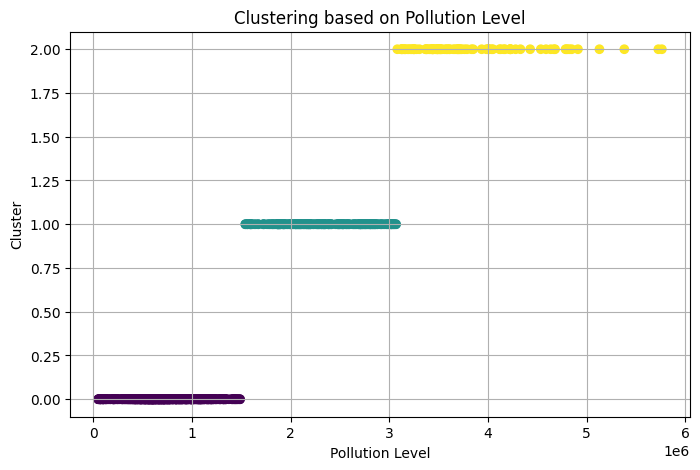

In [14]:
import pandas as pd
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# تحميل البيانات (من ملف CSV المحفوظ سابقًا)
df = pd.read_csv("waste_data.csv")

# حذف الأعمدة غير الضرورية
df = df.drop(columns=["name"])

# اختيار الأعمدة التي نحتاجها لتطبيق Clustering
data_for_clustering = df[["pollution_level"]]

# تطبيق K-Means Clustering مع 3 مجموعات
n_clusters = 3  # عدد المجموعات
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["cluster"] = kmeans.fit_predict(data_for_clustering)

# إعداد الألوان لكل Cluster
cluster_colors = {0: "green", 1: "blue", 2: "red"}

# حساب متوسط التلوث لكل Cluster
cluster_means = df.groupby("cluster")["pollution_level"].mean()

# إنشاء جدول جانبي للمتوسطات
print("\nAverage Pollution Level per Cluster:")
print(cluster_means)

# إنشاء الخريطة
map_clusters = folium.Map(location=[30.0444, 31.2357], zoom_start=7)

# إضافة النقاط مع ألوان Clusters وتخصيص الحجم بناءً على مستوى التلوث
for _, row in df.iterrows():
    color = cluster_colors[row["cluster"]]
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=row["pollution_level"] / 500000,  # تخصيص الحجم بناءً على التلوث
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=(
            f"Governorate: {row['governorate']}<br>"
            f"Pollution Level: {row['pollution_level']:.2f}<br>"
            f"Cluster: {row['cluster']}<br>"
            f"Mean Pollution (Cluster): {cluster_means[row['cluster']]:.2f}"
        )
    ).add_to(map_clusters)

# حفظ الخريطة
map_clusters.save("enhanced_clustered_map.html")
print("Enhanced map with clusters saved to 'enhanced_clustered_map.html'")

# عرض النتائج على Scatter Plot مع تحسين العرض
plt.figure(figsize=(8, 5))
plt.scatter(data_for_clustering["pollution_level"], df["cluster"], c=df["cluster"], cmap="viridis")
plt.title("Clustering based on Pollution Level")
plt.xlabel("Pollution Level")
plt.ylabel("Cluster")
plt.grid(True)
plt.show()


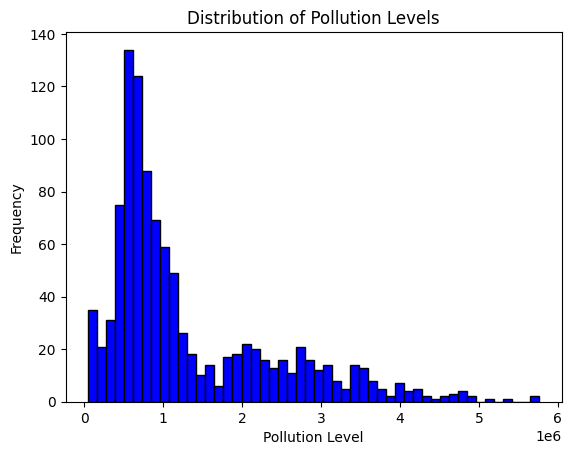

In [15]:
import matplotlib.pyplot as plt

plt.hist(df["pollution_level"], bins=50, color="blue", edgecolor="black")
plt.title("Distribution of Pollution Levels")
plt.xlabel("Pollution Level")
plt.ylabel("Frequency")
plt.show()


In [36]:
import numpy as np

# تطبيق Log Transformation لتقليل تأثير القيم المتطرفة
df["pollution_level_log"] = np.log1p(df["pollution_level"])


In [37]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df["pollution_level_normalized"] = scaler.fit_transform(df[["pollution_level_log"]])


In [38]:
from sklearn.cluster import KMeans

# تطبيق الكلاسترينج
n_clusters = 4  # تجربة عدد كتل أكبر
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["cluster"] = kmeans.fit_predict(df[["pollution_level_normalized"]])


C:\Users\abdal\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


C:\Users\abdal\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\abdal\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\abdal\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\abdal\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

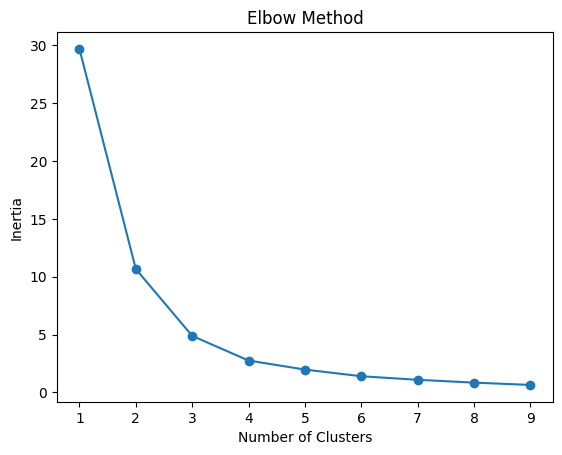

In [39]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# التأكد من وجود العمود وتطبيع القيم
if "pollution_level_normalized" not in df.columns:
    scaler = MinMaxScaler()
    df["pollution_level_normalized"] = scaler.fit_transform(df[["pollution_level"]])

# تطبيق Elbow Method
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[["pollution_level_normalized"]])  # استخدام العمود المطبع
    inertia.append(kmeans.inertia_)

# رسم النتائج
plt.plot(range(1, 10), inertia, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


In [40]:
from sklearn.cluster import KMeans
import folium
from folium.plugins import HeatMap

# تطبيق K-Means Clustering مع 3 مجموعات
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(df[["pollution_level_normalized"]])

# إعداد خريطة حرارية بناءً على مستوى التلوث
heat_data = [
    [row["latitude"], row["longitude"], row["pollution_level_normalized"]]
    for _, row in df.iterrows()
]

# إنشاء الخريطة
map_heat = folium.Map(location=[30.0444, 31.2357], zoom_start=7)

# إضافة Heat Map
HeatMap(
    heat_data,
    radius=15,  # حجم التأثير الحراري
    blur=10,    # تمويه النقاط لجعلها أكثر نعومة
    max_zoom=1,  # أقصى درجة تقريب
    gradient={0.2: "green", 0.5: "blue", 0.8: "red"}  # التدرج الحراري
).add_to(map_heat)

# حفظ الخريطة
map_heat.save("heat_map_pollution.html")
print("Heat map saved to 'heat_map_pollution.html'")


Heat map saved to 'heat_map_pollution.html'


In [41]:
from IPython.display import IFrame
IFrame('heat_map_pollution.html', width=1200, height=1000)


In [47]:
import overpy
import pandas as pd
import folium
from folium.plugins import HeatMap
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import random

# -------------------------------
# 1. جمع البيانات
# -------------------------------
# إعداد البيانات الأساسية
api = overpy.Overpass()
governorates = {
    "Cairo": (30.0444, 31.2357),
    "Giza": (29.987, 31.2118),
    "Alexandria": (31.2001, 29.9187),
    "Dakahlia": (31.0409, 31.3785),
    "Sharqia": (30.7306, 31.641),
    "Minya": (28.0900, 30.7600),
    "Sohag": (26.556, 31.695)
}
radius = 10000  # نصف القطر بالكيلومتر

data = []
for governorate, (lat, lon) in governorates.items():
    query = f"""
      [out:json];
      (
        node["amenity"="restaurant"](around:{radius},{lat},{lon});
        node["amenity"="hospital"](around:{radius},{lat},{lon});
        node["tourism"="hotel"](around:{radius},{lat},{lon});
      );
      out body;
    """
    result = api.query(query)
    for node in result.nodes:
        name = node.tags.get("name", "Unknown")
        amenity = node.tags.get("amenity", "Unknown")
        waste_type = (
            "organic" if amenity == "restaurant" else
            "medical" if amenity == "hospital" else
            "mixed" if amenity == "hotel" else "unknown"
        )
        data.append({
            "governorate": governorate,
            "latitude": node.lat,
            "longitude": node.lon,
            "name": name,
            "type": amenity,
            "waste_type": waste_type
        })

df = pd.DataFrame(data)

# -------------------------------
# 2. معالجة البيانات
# -------------------------------
# معالجة القيم غير المعروفة
df["type"] = df["type"].replace("Unknown", "hotel")
df["waste_type"] = df["waste_type"].replace("unknown", "mixed")

# إضافة كثافة سكانية ونفايات
def generate_population_density(governorate):
    return random.randint(10000, 20000) if governorate in ["Cairo", "Giza", "Alexandria"] else random.randint(1000, 5000)

def generate_waste_weight(waste_type):
    if waste_type == "organic":
        return random.randint(30, 70)
    elif waste_type == "medical":
        return random.randint(150, 300)
    elif waste_type == "mixed":
        return random.randint(100, 200)
    return 0

df["population_density"] = df["governorate"].apply(generate_population_density)
df["waste_weight"] = df["waste_type"].apply(generate_waste_weight)

# حساب مستوى التلوث
df["pollution_level"] = df["population_density"] * df["waste_weight"]

# -------------------------------
# 3. تطبيق التطبيع والكلاسترينج
# -------------------------------
# تطبيع مستوى التلوث
scaler = MinMaxScaler()
df["pollution_level_normalized"] = scaler.fit_transform(df[["pollution_level"]])

# تطبيق K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(df[["pollution_level_normalized"]])

# -------------------------------
# 4. إنشاء الخريطة
# -------------------------------
map_combined = folium.Map(location=[30.0444, 31.2357], zoom_start=7)

# 4.1 عرض النقاط الفردية (طبقة منفصلة)
points_layer = folium.FeatureGroup(name="Locations")
for _, row in df.iterrows():
    color = "green" if row["type"] == "restaurant" else "red" if row["type"] == "hospital" else "blue"
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=7,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=(
            f"Name: {row['name']}<br>"
            f"Governorate: {row['governorate']}<br>"
            f"Type: {row['type']}<br>"
            f"Waste Type: {row['waste_type']}<br>"
            f"Pollution Level: {row['pollution_level']:.2f}"
        )
    ).add_to(points_layer)
points_layer.add_to(map_combined)

# 4.2 عرض الخريطة الحرارية (طبقة منفصلة)
heat_layer = folium.FeatureGroup(name="Pollution Heat Map")
heat_data = [
    [row["latitude"], row["longitude"], row["pollution_level_normalized"]]
    for _, row in df.iterrows()
]
HeatMap(
    heat_data,
    radius=20,
    blur=15,
    gradient={0: "blue", 0.5: "yellow", 1: "red"}
).add_to(heat_layer)
heat_layer.add_to(map_combined)

# إضافة التحكم في الطبقات
folium.LayerControl().add_to(map_combined)

# حفظ الخريطة
map_combined.save("final_map_with_layers.html")
print("Final combined map with layers saved as 'final_map_with_layers.html'")


Final combined map with layers saved as 'final_map_with_layers.html'


In [48]:
from IPython.display import IFrame
IFrame('final_map_with_layers.html', width=800, height=600)
